In [101]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd
import copy

In [102]:
def P_0_matrix(x):
    P_0_matrix=np.array([[x,0,0,1-x],
                   [1-x,x,0,0],
                   [0,1-x,x,0],
                   [0,0,1-x,x]])  
    return P_0_matrix

In [103]:
def P_1_matrix(x):
    P_0_matrix=np.array([[x,0,0,1-x],
                   [1-x,x,0,0],
                   [0,1-x,x,0],
                   [0,0,1-x,x]])  
    return P_0_matrix.transpose()

In [104]:
P_1_matrix(0.5)

array([[0.5, 0.5, 0. , 0. ],
       [0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5],
       [0.5, 0. , 0. , 0.5]])

In [105]:
action_space=[0,1]
state_space=[0,1,2,3]
reward_matrix=[[-1,-1],[0,0],[0,0],[1,1]]

In [106]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [107]:
new_state=np.random.choice(state_space,replace=True,p=P_1_matrix(0.5)[2])
new_state

3

In [108]:
N=5
M=2
epsilon=0.1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [109]:
Q_values=[]
for i in range(0,N):
  Q_values.append(copy.deepcopy(reward_matrix))
  
Q_values

[[[-1, -1], [0, 0], [0, 0], [1, 1]],
 [[-1, -1], [0, 0], [0, 0], [1, 1]],
 [[-1, -1], [0, 0], [0, 0], [1, 1]],
 [[-1, -1], [0, 0], [0, 0], [1, 1]],
 [[-1, -1], [0, 0], [0, 0], [1, 1]]]

In [110]:
Q_values_whittle=copy.deepcopy(Q_values)

In [111]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
    return Q_values

  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
    return Q_values




In [112]:
def Q_value_update2(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
    return Q_values

  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
    return Q_values


In [113]:
def act(Q_values,epsilon,state,arm_index):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[arm_index][state])
  return action

In [114]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]  

In [115]:
whittle_indexes=[]
for _ in range(N):
    whittle_indexes.append([0 for _ in range(len(state_space))])
whittle_indexes

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [116]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1
whittle_indexes_over_time=[]
whittle_indexes_over_time.append(copy.deepcopy(whittle_indexes))
whittle_indexes_over_time

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]

In [117]:
for i in range(1,1000001):
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/10000))
  if i%50==0:
    beta=1/(1+(i*np.log(i)/10000))
  else:
    beta=0
  epsilon=0.1
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix((index+3)/10.0),P_1_matrix((index+3)/10.0),reward_matrix)
      new_state=x[0]
      reward=x[1]
      Q_values=Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      temp=Q_values_whittle[index][current_state[index]][1]-Q_values_whittle[index][current_state[index]][0]
      Q_values_whittle=Q_value_update2(Q_values_whittle,current_state[index],new_state,action,reward,index,whittle_indexes[index][current_state[index]],alpha)
      whittle_indexes[index][current_state[index]]+=beta*temp
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  # print(whittle_indexes)
  # print(current_state[index])
  # print(Q_values[index][current_state[index]][1])
  # print(Q_values[index][current_state[index]][0])
  # print((Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]))
  # print('----')

  whittle_indexes_over_time.append(copy.deepcopy(whittle_indexes))
  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  # epsilon=epsilon*gamma
  # if epsilon<=0.01:
  #   epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








In [118]:
Q_values_whittle


[[[-1.0453452126723726, -1.0751604685475356],
  [0.3658589209171207, 0.37174826576005293],
  [0.3852124295269298, 0.3719503739662599],
  [0.37941912381979337, 0.3311422937892162]],
 [[-1.185332124341698, -1.2576101567418287],
  [0.5115238507436477, 0.4269973800210462],
  [0.45124751005381575, 0.4879318173240486],
  [0.479755293462854, 0.5935968247772662]],
 [[-1.5141304689821153, -1.5129337859025265],
  [0.5216108793263112, 0.5403299189767848],
  [0.5300963267130904, 0.5147388354775722],
  [0.49475287026238735, 0.510047767560391]],
 [[-1.8416384746519596, -1.911474811124195],
  [0.40081423564630364, 0.6840942049728103],
  [0.7321724048849109, 0.7072077686363784],
  [0.6788805616539185, 0.5373222170574015]],
 [[-2.610162268875547, -2.375602538907583],
  [0.8063386953990742, 0.8032029953977503],
  [0.8919164465443045, 0.8818633232426341],
  [0.9834829237824785, 1.0824680249853635]]]

Text(0.5, 1.0, 'Subsidy vs Steps for Circular Example')

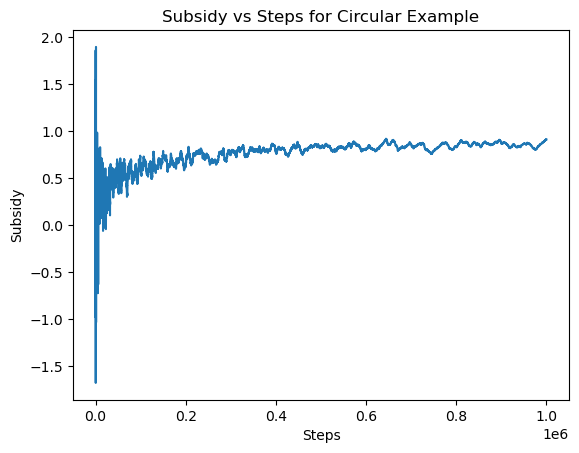

In [119]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Circular Example')

In [120]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Circular Example ')

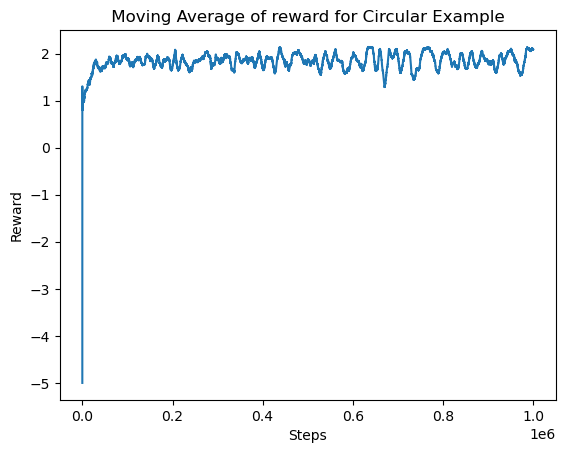

In [121]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Circular Example ')
# plt.savefig('Moving Average of reward for Circular Example.png')

Text(0.5, 1.0, ' Moving Average of number of arms activated for Circular Example ')

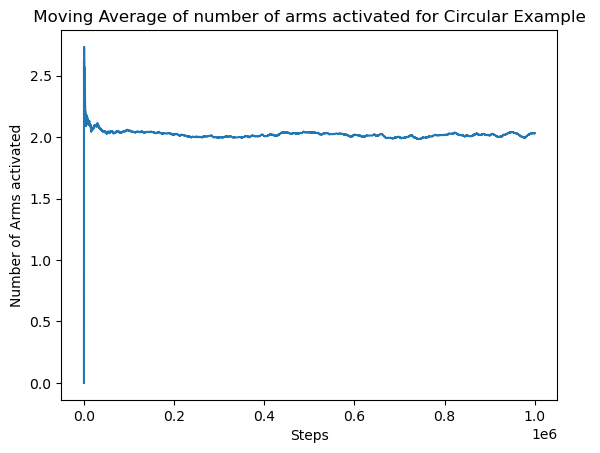

In [122]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(200000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Circular Example ')
# plt.savefig('Moving Average of number of arms activated for Restart Example.png')

In [123]:
# #plotting evolution of whittle indexes of arm 9 states

# state1=[whittle_indexes_over_time[i][8][0] for i in range(500000)]
# state2=[whittle_indexes_over_time[i][8][1] for i in range(500000)]
# state3=[whittle_indexes_over_time[i][8][2] for i in range(500000)]
# state4=[whittle_indexes_over_time[i][8][3] for i in range(500000)]
# state5=[whittle_indexes_over_time[i][8][4] for i in range(500000)]
# plt.plot(state1,color='r')
# plt.plot(state2,color='g')
# plt.plot(state3,color='b')
# plt.plot(state4,color='y')
# plt.plot(state5,color='purple')
# plt.ylim([-1,0])


In [124]:
whittle_indexes_over_time[0][2][1]

0

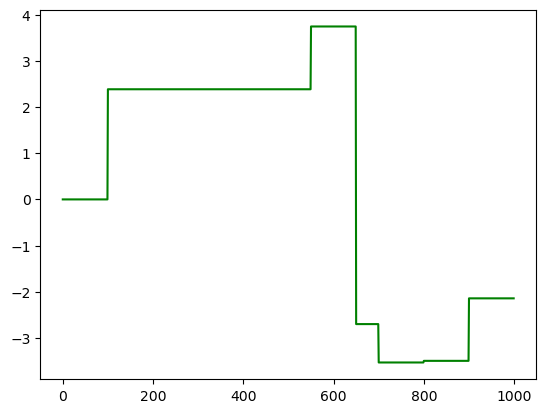

In [125]:
state2=[whittle_indexes_over_time[i][2][2] for i in range(1000)]
plt.plot(state2,color='g',label='state 2')

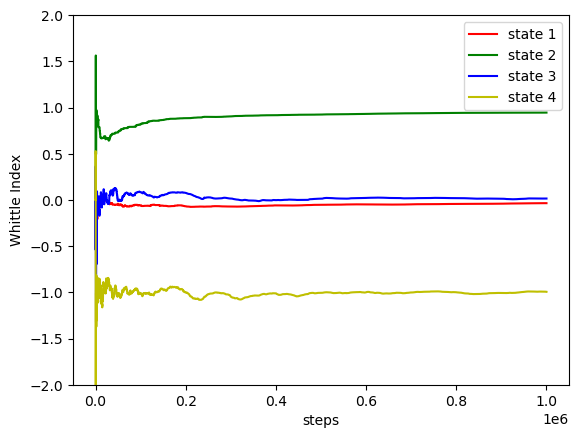

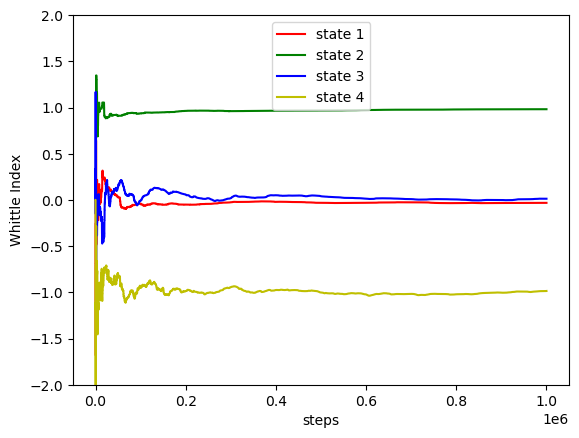

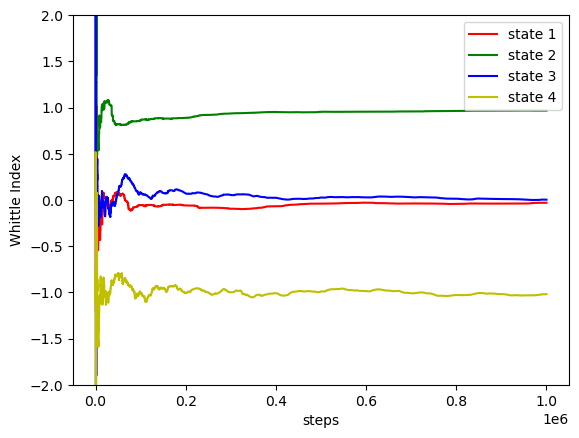

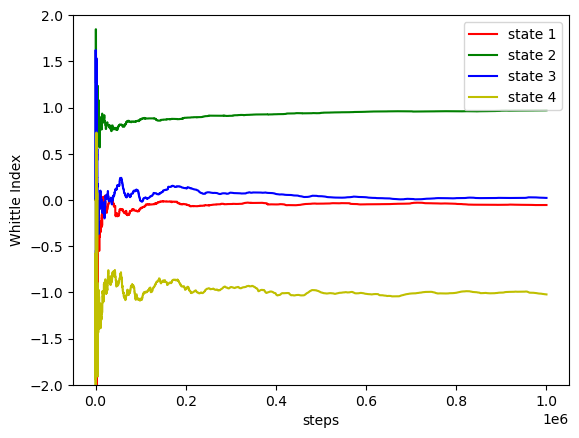

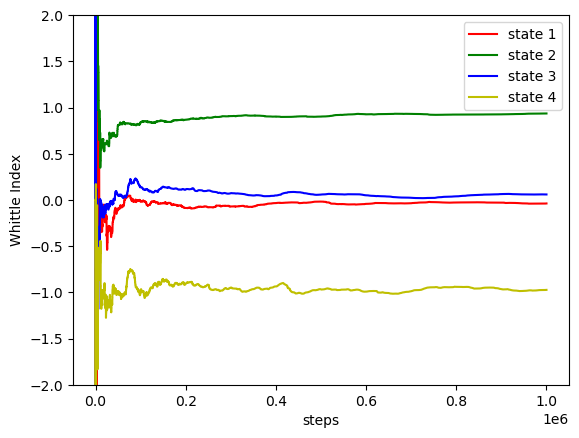

In [126]:
#plotting evolution of whittle indexes of arm 8 states
t=1000000
for j in range(N):
    state1=[whittle_indexes_over_time[i][j][0] for i in range(t)]
    state2=[whittle_indexes_over_time[i][j][1] for i in range(t)]
    state3=[whittle_indexes_over_time[i][j][2] for i in range(t)]
    state4=[whittle_indexes_over_time[i][j][3] for i in range(t)]
    plt.figure()
    plt.plot(state1,color='r',label='state 1')
    plt.plot(state2,color='g',label='state 2')
    plt.plot(state3,color='b',label='state 3')
    plt.plot(state4,color='y',label='state 4')
    plt.legend()
    plt.ylabel('Whittle Index')
    plt.xlabel('steps')
    plt.ylim([-2,2])
    plt.show()


In [127]:
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix((index+3)/10.0),P_1_matrix((index+3)/10.0),reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix((index+3)/10.0),P_1_matrix((index+3)/10.0),reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)

In [128]:
Q_values[0]

[[1.1197171383705313, -0.9720660800565499],
 [1.0021078295254071, 0.21330286011058194],
 [1.007151384862312, 1.1911549370718684],
 [2.645915714024576, 1.5266403570322535]]

In [129]:
reward_sums_whittle_index=[]
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=whittle_indexes[index][current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
#   print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix((index+3)/10.0),P_1_matrix((index+3)/10.0),reward_matrix)
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix((index+3)/10.0),P_1_matrix((index+3)/10.0),reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

In [130]:
Q_values_whittle[3]

[[-1.8416384746519596, -1.911474811124195],
 [0.40081423564630364, 0.6840942049728103],
 [0.7321724048849109, 0.7072077686363784],
 [0.6788805616539185, 0.5373222170574015]]

Text(0.5, 1.0, ' Moving Average of reward for Circular Example ')

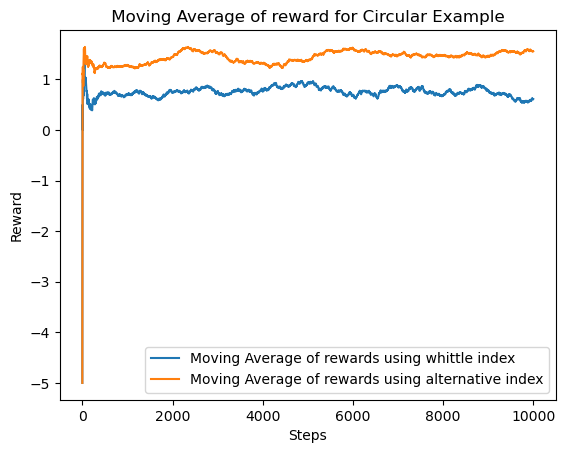

In [131]:
df_rewards=pd.DataFrame()
df_rewards['reward_whittle']=reward_sums_whittle_index
df_rewards['reward_alternate']=reward_sums_alt_index

plt.plot(df_rewards['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df_rewards['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Circular Example ')